In [16]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm  # Use notebook version if in Colab/Jupyter
import warnings
import pickle # To save mappings

In [17]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
FILE_PATH = "/content/DBPEDIA_train.csv"

In [19]:
def load_data(file_path):
    """Loads data from CSV."""
    print(f"Loading data from: {file_path}")
    try:
        df = pd.read_csv(file_path)
        # Optional: Rename columns for consistency if needed
        # df = df.rename(columns={'old_col1': 'l1', 'old_col2': 'l2'})
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [20]:
load_data(FILE_PATH)

Loading data from: /content/DBPEDIA_train.csv
Dataset shape: (240942, 4)
Columns: ['text', 'l1', 'l2', 'l3']


,text,l1,l2,l3
0,"William Alexander Massey (October 7, 1856 – Ma...",Agent,Politician,Senator
1,Lions is the sixth studio album by American ro...,Work,MusicalWork,Album
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...",Place,NaturalPlace,Mountain
3,Cancer Prevention Research is a biweekly peer-...,Work,PeriodicalLiterature,AcademicJournal
4,The Princeton University Chapel is located on ...,Place,Building,HistoricBuilding
...,...,...,...,...
240937,Charlie Thompson is a prominent journalist in ...,Agent,Person,Journalist
240938,The Northerly Stakes is a Perth Racing Group 3...,Event,Race,HorseRace
240939,HC Empor Rostock is a team handball club from ...,Agent,SportsTeam,HandballTeam
240940,University of Surabaya (UBAYA) is a university...,Agent,EducationalInstitution,University


In [21]:
def preprocess_text(text):
    """Cleans and preprocesses a single text string."""
    if not isinstance(text, str):
        return "" # Handle non-string inputs (like NaN)

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation and special chars
    text = re.sub(r'\d+', '', text) # Remove numbers

    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1] # Keep words longer than 1 char

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [22]:
df = load_data(FILE_PATH)

Loading data from: /content/DBPEDIA_train.csv
Dataset shape: (240942, 4)
Columns: ['text', 'l1', 'l2', 'l3']


In [23]:
TEXT_COL = 'text' # The single column containing the input text
LABEL_COLS = ['l1', 'l2', 'l3']    # Hierarchy levels

In [24]:
warnings.filterwarnings('ignore')
tqdm.pandas()

In [25]:
if df is not None:
    print("\nInitial Data Info:")
    df.info()
    print("\nMissing values before processing:")
    print(df.isnull().sum()) # Check NaNs in text and labels

    # --- Text Preprocessing ---
    print(f"\nPerforming initial text preprocessing on column '{TEXT_COL}'...")

    # Handle potential missing values in the text column before processing
    original_text_nan_count = df[TEXT_COL].isnull().sum()
    if original_text_nan_count > 0:
        print(f"Warning: Found {original_text_nan_count} NaN values in '{TEXT_COL}'. Filling with empty string for preprocessing.")
        df[TEXT_COL] = df[TEXT_COL].fillna('')

    # Apply detailed text preprocessing
    print("Applying NLTK preprocessing (lemmatization, stopwords, etc.)...")
    # Cache lemmatizer and stopwords for slight speedup
    lemmatizer_cache = WordNetLemmatizer()
    stopwords_cache = set(stopwords.words('english'))
    def preprocess_text_cached(text):
        # No need to check instance type here as we filled NaNs above
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords_cache and len(word) > 1]
        tokens = [lemmatizer_cache.lemmatize(word) for word in tokens]
        return ' '.join(tokens)

    # Create the 'processed_text' column
    df['processed_text'] = df[TEXT_COL].progress_apply(preprocess_text_cached)

    print("\nText preprocessing complete.")
    print("Sample processed text:")
    # Show original 'text' and the new 'processed_text'
    print(df[[TEXT_COL, 'processed_text']].head())

    # Optional: Drop original text column to save memory if no longer needed
    # df = df.drop(columns=[TEXT_COL])
    # print(f"Dropped original '{TEXT_COL}' column.")

else:
    print("Stopping execution due to data loading failure.")

# Display memory usage
if df is not None:
    print("\nDataFrame memory usage after Stage 1:")
    df.info(memory_usage='deep')



Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240942 entries, 0 to 240941
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    240942 non-null  object
 1   l1      240942 non-null  object
 2   l2      240942 non-null  object
 3   l3      240942 non-null  object
dtypes: object(4)
memory usage: 7.4+ MB

Missing values before processing:
text    0
l1      0
l2      0
l3      0
dtype: int64

Performing initial text preprocessing on column 'text'...
Applying NLTK preprocessing (lemmatization, stopwords, etc.)...


  0%|          | 0/240942 [00:00<?, ?it/s]


Text preprocessing complete.
Sample processed text:
                                                text  \
0  William Alexander Massey (October 7, 1856 – Ma...   
1  Lions is the sixth studio album by American ro...   
2  Pirqa (Aymara and Quechua for wall, hispaniciz...   
3  Cancer Prevention Research is a biweekly peer-...   
4  The Princeton University Chapel is located on ...   

                                      processed_text  
0  william alexander massey october march united ...  
1  lion sixth studio album american rock band bla...  
2  pirqa aymara quechua wall hispanicized spellin...  
3  cancer prevention research biweekly peerreview...  
4  princeton university chapel located university...  

DataFrame memory usage after Stage 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240942 entries, 0 to 240941
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            240942 non-null  obj

In [26]:
MAPPINGS_SAVE_PATH = 'label_mappings.pkl' # Define where to save the mappings

# --- Main Execution ---

if 'df' in locals() and df is not None: # Check if df exists and is not None
    print("\n--- Stage 2: Label Identification and Mapping ---")

    # --- Identify Unique Labels ---
    print("Identifying unique labels across specified columns:", LABEL_COLS)
    all_labels_set = set()
    labels_found_count = 0

    for col in LABEL_COLS:
        if col in df.columns:
            unique_col_labels = df[col].dropna().unique()
            count = len(unique_col_labels)
            if count > 0:
                all_labels_set.update(unique_col_labels)
                print(f"  - Found {count} unique non-NaN labels in column '{col}'.")
                labels_found_count += count
            else:
                print(f"  - No non-NaN labels found in column '{col}'.")
        else:
            print(f"  - Warning: Label column '{col}' not found in DataFrame. Skipping.")

    if not all_labels_set:
        print("\nError: No unique labels found in any of the specified columns. Cannot proceed.")
        # Handle this error appropriately, maybe exit or raise an exception
        # For now, we'll prevent saving empty mappings
        mappings = None
    else:
        # --- Create Mappings ---
        # Sort labels for consistent index assignment across runs
        all_labels_list = sorted(list(all_labels_set))
        num_unique_labels = len(all_labels_list)
        print(f"\nTotal unique non-NaN labels identified: {num_unique_labels}")

        # Create label <-> index dictionaries
        label_to_index = {label: i for i, label in enumerate(all_labels_list)}
        index_to_label = {i: label for label, i in label_to_index.items()}

        print("Created label-to-index and index-to-label mappings.")
        # Example: Print first 10 mappings if needed for verification
        if num_unique_labels > 0:
             print("Sample mapping (first 10):")
             for i, label in enumerate(all_labels_list[:10]):
                 print(f"  Index {label_to_index[label]}: '{label}'")

        # --- Store Mappings ---
        # Bundle mappings into a dictionary for saving
        mappings = {
            'label_to_index': label_to_index,
            'index_to_label': index_to_label,
            'all_labels_list': all_labels_list, # List of labels in index order
            'label_columns_used': LABEL_COLS   # Record which columns were used
        }

        print(f"\nAttempting to save mappings to: {MAPPINGS_SAVE_PATH}")
        try:
            with open(MAPPINGS_SAVE_PATH, 'wb') as f:
                pickle.dump(mappings, f)
            print(f"Successfully saved label mappings.")
        except IOError as e:
            print(f"Error: Could not write mappings file to '{MAPPINGS_SAVE_PATH}'. Check permissions.")
            print(f"  System error: {e}")
            mappings = None # Indicate failure
        except Exception as e:
            print(f"An unexpected error occurred while saving mappings: {e}")
            mappings = None # Indicate failure

    # --- Final Check ---
    if mappings:
        print("\nStage 2 completed successfully. Mappings are ready.")
        # You can now proceed to Stage 3 using these mappings
        # Keep the 'mappings' variable in memory if Stage 3 runs immediately after,
        # otherwise, Stage 3 will need to load 'label_mappings.pkl'.
    else:
        print("\nStage 2 completed with errors or no labels found. Mappings were not saved/created.")

else:
    print("\nSkipping Stage 2: DataFrame 'df' is not available or was not loaded correctly in Stage 1.")


--- Stage 2: Label Identification and Mapping ---
Identifying unique labels across specified columns: ['l1', 'l2', 'l3']
  - Found 9 unique non-NaN labels in column 'l1'.
  - Found 70 unique non-NaN labels in column 'l2'.
  - Found 219 unique non-NaN labels in column 'l3'.

Total unique non-NaN labels identified: 298
Created label-to-index and index-to-label mappings.
Sample mapping (first 10):
  Index 0: 'AcademicJournal'
  Index 1: 'Actor'
  Index 2: 'AdultActor'
  Index 3: 'Agent'
  Index 4: 'Airline'
  Index 5: 'Airport'
  Index 6: 'Album'
  Index 7: 'AmateurBoxer'
  Index 8: 'Ambassador'
  Index 9: 'AmericanFootballPlayer'

Attempting to save mappings to: label_mappings.pkl
Successfully saved label mappings.

Stage 2 completed successfully. Mappings are ready.


In [27]:
HIERARCHY_SAVE_PATH = 'label_hierarchy_info.pkl'
MAPPINGS_LOAD_PATH = '/content/label_mappings.pkl'

In [28]:
print("--- Stage 3: Building Hierarchy Information for Severity ---")

# Load Mappings from Stage 2
try:
    with open(MAPPINGS_LOAD_PATH, 'rb') as f:
        mappings = pickle.load(f)
    print(f"Successfully loaded mappings from {MAPPINGS_LOAD_PATH}")
    label_to_index = mappings['label_to_index']
    index_to_label = mappings['index_to_label']
    all_labels_list = mappings['all_labels_list']
    num_unique_labels = len(all_labels_list)
except FileNotFoundError:
    print(f"Error: Mappings file not found at {MAPPINGS_LOAD_PATH}. Run Stage 2 first.")
    mappings = None
except Exception as e:
    print(f"Error loading mappings: {e}")
    mappings = None

--- Stage 3: Building Hierarchy Information for Severity ---
Successfully loaded mappings from /content/label_mappings.pkl


In [29]:
if mappings is not None and 'df' in locals() and df is not None:
    print("\nExtracting unique hierarchical combinations from the data...")
    # Use drop_duplicates on the relevant label columns to find unique paths
    # Convert potential float NaNs to actual None for consistent handling
    hierarchy_df = df[LABEL_COLS].astype(object).where(pd.notnull(df[LABEL_COLS]), None)
    unique_hierarchies = hierarchy_df.drop_duplicates().reset_index(drop=True)
    print(f"Found {len(unique_hierarchies)} unique hierarchical combinations to process.")

    # Initialize the dictionary to store hierarchy info
    # Key: label_index, Value: dict{'label', 'l1', 'l2', 'l3', 'level'}
    label_hierarchy_info = {}

    print("\nBuilding hierarchy information lookup...")
    # Iterate through unique combinations
    for _, row in tqdm(unique_hierarchies.iterrows(), total=len(unique_hierarchies), desc="Processing Hierarchies"):
        l1_val, l2_val, l3_val = row[LABEL_COLS[0]], row[LABEL_COLS[1]], row[LABEL_COLS[2]]

        # Process l1 label from this path
        if l1_val is not None:
            l1_idx = label_to_index.get(l1_val)
            if l1_idx is not None and l1_idx not in label_hierarchy_info:
                label_hierarchy_info[l1_idx] = {
                    'label': l1_val,
                    'l1': l1_val,  # l1 is its own parent at level 1
                    'l2': None,
                    'l3': None,
                    'level': 1
                }

        # Process l2 label from this path (requires l1)
        if l1_val is not None and l2_val is not None:
            l2_idx = label_to_index.get(l2_val)
            if l2_idx is not None and l2_idx not in label_hierarchy_info:
                label_hierarchy_info[l2_idx] = {
                    'label': l2_val,
                    'l1': l1_val,  # Store its actual l1 parent
                    'l2': l2_val,  # l2 is its own parent at level 2
                    'l3': None,
                    'level': 2
                }
            # Optional: Add consistency check - if l2_idx exists, ensure parent l1 matches
            elif l2_idx is not None and label_hierarchy_info[l2_idx]['l1'] != l1_val:
                 print(f"Warning: Inconsistent parent for label '{l2_val}' (Index {l2_idx}). Found parent '{l1_val}' but previously recorded '{label_hierarchy_info[l2_idx]['l1']}'. Keeping first one.")


        # Process l3 label from this path (requires l1 and l2)
        if l1_val is not None and l2_val is not None and l3_val is not None:
            l3_idx = label_to_index.get(l3_val)
            if l3_idx is not None and l3_idx not in label_hierarchy_info:
                label_hierarchy_info[l3_idx] = {
                    'label': l3_val,
                    'l1': l1_val,  # Store its actual l1 parent
                    'l2': l2_val,  # Store its actual l2 parent
                    'l3': l3_val,  # l3 is its own parent at level 3
                    'level': 3
                }
            # Optional: Add consistency check
            elif l3_idx is not None and (label_hierarchy_info[l3_idx]['l1'] != l1_val or label_hierarchy_info[l3_idx]['l2'] != l2_val):
                 print(f"Warning: Inconsistent parents for label '{l3_val}' (Index {l3_idx}). Found parents '{l1_val}'->'{l2_val}' but previously recorded '{label_hierarchy_info[l3_idx]['l1']}'->'{label_hierarchy_info[l3_idx]['l2']}'. Keeping first one.")


    print(f"\nInitial hierarchy built for {len(label_hierarchy_info)} labels based on unique paths.")

    # --- Verification Step ---
    # Check if any labels from the mapping are missing hierarchy info
    # This catches labels that might only appear as parents (l1 or l2) and never as the "deepest" label in a row.
    missing_label_indices = []
    for idx in range(num_unique_labels):
        if idx not in label_hierarchy_info:
            missing_label_indices.append(idx)

    if missing_label_indices:
        print(f"\nVerification: Found {len(missing_label_indices)} labels missing hierarchy info. Attempting to resolve...")
        resolved_count = 0
        unresolved_labels = []

        for idx in tqdm(missing_label_indices, desc="Resolving Missing"):
            label_to_find = index_to_label[idx]
            found_info = False

            # Search again in unique hierarchies to find its path as a parent
            for _, row in unique_hierarchies.iterrows():
                 l1_val, l2_val, _ = row[LABEL_COLS[0]], row[LABEL_COLS[1]], row[LABEL_COLS[2]] # l3 not needed here

                 # Check if it's an l2 label whose l1 parent we know
                 if l2_val == label_to_find and l1_val is not None:
                     l1_idx_parent = label_to_index.get(l1_val)
                     # Ensure parent itself has info (should from initial pass or earlier in verification)
                     if l1_idx_parent in label_hierarchy_info or l1_val == label_to_find: # handle self-reference cases if any
                         label_hierarchy_info[idx] = {
                             'label': label_to_find,
                             'l1': l1_val,
                             'l2': label_to_find,
                             'l3': None,
                             'level': 2
                         }
                         found_info = True
                         resolved_count += 1
                         break # Found info for this label

                 # Check if it's an l1 label
                 if l1_val == label_to_find:
                      label_hierarchy_info[idx] = {
                          'label': label_to_find,
                          'l1': label_to_find,
                          'l2': None,
                          'l3': None,
                          'level': 1
                      }
                      found_info = True
                      resolved_count += 1
                      break # Found info for this label

            if not found_info:
                unresolved_labels.append(label_to_find)

        print(f"Resolved hierarchy for {resolved_count} additional labels.")
        if unresolved_labels:
            print(f"Warning: Could not automatically determine hierarchy for {len(unresolved_labels)} labels: {unresolved_labels[:20]}...")
            print("  This might indicate data inconsistency or labels present in mapping but not used in hierarchy.")

    print(f"\nFinal hierarchy information compiled for {len(label_hierarchy_info)} out of {num_unique_labels} total labels.")

    # --- Store Hierarchy Info ---
    if label_hierarchy_info: # Only save if not empty
        print(f"\nAttempting to save hierarchy info to: {HIERARCHY_SAVE_PATH}")
        try:
            with open(HIERARCHY_SAVE_PATH, 'wb') as f:
                pickle.dump(label_hierarchy_info, f)
            print(f"Successfully saved label hierarchy info.")
        except IOError as e:
            print(f"Error: Could not write hierarchy info file to '{HIERARCHY_SAVE_PATH}'. Check permissions.")
            print(f"  System error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred while saving hierarchy info: {e}")
    else:
        print("\nWarning: Hierarchy info dictionary is empty. Nothing saved.")


    # --- Optional: Add Ground Truth Hierarchy Strings to DataFrame ---
    print("\nAdding ground truth label strings (gt_l1, gt_l2, gt_l3) to DataFrame...")
    for col in LABEL_COLS:
        if col in df.columns:
            # Convert to string, explicitly making NaNs the string 'None' for clarity
            df[f'gt_{col}'] = df[col].astype(object).where(pd.notnull(df[col]), 'None').astype(str)
        else:
            df[f'gt_{col}'] = 'None' # Placeholder if column was missing

    print("Added ground truth columns.")
    print("DataFrame columns now include:", [col for col in df.columns if col.startswith('gt_')])
    print("Sample ground truth values:")
    print(df[[f'gt_{col}' for col in LABEL_COLS]].head())

    # --- Optional: Save the updated DataFrame ---
    # print(f"\nAttempting to save updated DataFrame to: {DATAFRAME_SAVE_PATH}")
    # try:
    #     df.to_pickle(DATAFRAME_SAVE_PATH)
    #     print("Successfully saved updated DataFrame.")
    # except Exception as e:
    #     print(f"Error saving updated DataFrame: {e}")

    print("\nStage 3 completed.")

elif mappings is None:
    print("\nSkipping Stage 3: Label mappings are required but were not loaded.")
else: # df is None or not in locals()
    print("\nSkipping Stage 3: DataFrame 'df' is not available.")

# The primary output is 'label_hierarchy_info.pkl' and the updated 'df' (if kept in memory or saved)
# with 'gt_' columns. The 'label_hierarchy_info' structure is critical for the custom loss function.


Extracting unique hierarchical combinations from the data...
Found 219 unique hierarchical combinations to process.

Building hierarchy information lookup...


Processing Hierarchies:   0%|          | 0/219 [00:00<?, ?it/s]


Initial hierarchy built for 298 labels based on unique paths.

Final hierarchy information compiled for 298 out of 298 total labels.

Attempting to save hierarchy info to: label_hierarchy_info.pkl
Successfully saved label hierarchy info.

Adding ground truth label strings (gt_l1, gt_l2, gt_l3) to DataFrame...
Added ground truth columns.
DataFrame columns now include: ['gt_l1', 'gt_l2', 'gt_l3']
Sample ground truth values:
   gt_l1                 gt_l2             gt_l3
0  Agent            Politician           Senator
1   Work           MusicalWork             Album
2  Place          NaturalPlace          Mountain
3   Work  PeriodicalLiterature   AcademicJournal
4  Place              Building  HistoricBuilding

Stage 3 completed.


In [30]:
HIERARCHY_INFO_LOAD_PATH = '/content/label_hierarchy_info.pkl'
GRAPH_SAVE_PATH = 'dbpedia_label_hierarchy.gpickle'

In [31]:
print("--- Stage 3.5: Knowledge Graph Construction ---") # Renaming slightly for clarity

# Load Mappings from Stage 2
try:
    with open(MAPPINGS_LOAD_PATH, 'rb') as f:
        mappings = pickle.load(f)
    print(f"Successfully loaded mappings from {MAPPINGS_LOAD_PATH}")
    all_labels_list = mappings['all_labels_list'] # Needed for nodes
    num_unique_labels = len(all_labels_list)
except FileNotFoundError:
    print(f"Error: Mappings file not found at {MAPPINGS_LOAD_PATH}. Run Stage 2 first.")
    mappings = None
except Exception as e:
    print(f"Error loading mappings: {e}")
    mappings = None

--- Stage 3.5: Knowledge Graph Construction ---
Successfully loaded mappings from /content/label_mappings.pkl


In [32]:
import networkx as nx

In [33]:
if mappings is not None and unique_hierarchies is not None:
    print("\nInitializing Directed Knowledge Graph...")
    G = nx.DiGraph() # Create a Directed Graph

    # --- Add Nodes ---
    print(f"Adding {num_unique_labels} unique labels as nodes...")
    for label in all_labels_list:
        G.add_node(label) # Add each unique label string as a node

    # --- Add Node Attributes (Optional but Recommended) ---
    if label_hierarchy_info is not None:
        print("Adding 'level' attribute to nodes based on hierarchy info...")
        nodes_missing_attributes = 0
        # Assuming label_hierarchy_info is keyed by index, need mapping back
        # index_to_label = mappings['index_to_label']
        # Let's re-check how label_hierarchy_info was structured. It was {index: {info}}
        # We need to iterate through it and use the 'label' field for node name
        for idx, info in label_hierarchy_info.items():
             node_name = info.get('label')
             level = info.get('level')
             if node_name in G: # Check if node exists (it should)
                 if level is not None:
                     G.nodes[node_name]['level'] = level
                 else:
                     # Assign a default level if missing? Or leave attribute absent?
                     # G.nodes[node_name]['level'] = 0 # Example default
                     pass # Leave attribute absent if level wasn't determined
             else:
                  # This case should ideally not happen if all_labels_list was accurate
                  nodes_missing_attributes += 1
        if nodes_missing_attributes > 0:
             print(f"Warning: Could not find {nodes_missing_attributes} nodes in the graph when adding attributes.")
        print("Node attributes added.")
    else:
        print("Skipping node attribute addition as hierarchy info was not loaded.")


    # --- Add Edges ---
    print("Adding edges based on hierarchical relationships (l1->l2, l2->l3)...")
    edge_count = 0
    skipped_edges = 0
    # Iterate through the unique combinations dataframe
    for _, row in tqdm(unique_hierarchies.iterrows(), total=len(unique_hierarchies), desc="Adding Edges"):
        l1_val, l2_val, l3_val = row[LABEL_COLS[0]], row[LABEL_COLS[1]], row[LABEL_COLS[2]]

        # Add edge from l1 to l2 if both exist and are valid labels in our nodes
        if l1_val is not None and l2_val is not None:
            if G.has_node(l1_val) and G.has_node(l2_val):
                if not G.has_edge(l1_val, l2_val): # Avoid adding duplicate edges message if not needed
                    G.add_edge(l1_val, l2_val)
                    edge_count += 1
            else:
                skipped_edges += 1 # Count edges skipped due to nodes not existing (shouldn't happen)

        # Add edge from l2 to l3 if both exist and are valid labels in our nodes
        if l2_val is not None and l3_val is not None:
             if G.has_node(l2_val) and G.has_node(l3_val):
                if not G.has_edge(l2_val, l3_val):
                    G.add_edge(l2_val, l3_val)
                    edge_count += 1
             else:
                skipped_edges += 1

    print(f"Added {edge_count} unique edges to the graph.")
    if skipped_edges > 0:
        print(f"Warning: Skipped {skipped_edges} potential edges because one or both nodes were not found in the graph.")


Initializing Directed Knowledge Graph...
Adding 298 unique labels as nodes...
Adding 'level' attribute to nodes based on hierarchy info...
Node attributes added.
Adding edges based on hierarchical relationships (l1->l2, l2->l3)...


Adding Edges:   0%|          | 0/219 [00:00<?, ?it/s]

Added 289 unique edges to the graph.


In [34]:
print(f"\nAttempting to save the graph object using standard pickle to: {GRAPH_SAVE_PATH}")
try:
  with open(GRAPH_SAVE_PATH, 'wb') as f: # Open file in binary write mode ('wb')
            pickle.dump(G, f, pickle.HIGHEST_PROTOCOL) # Dump the graph object G to file f
  print(f"Successfully saved graph to {GRAPH_SAVE_PATH}")
  print("You can now proceed with Stage 4 and subsequent stages.")
  print(f"Remember to load it using 'pickle.load()' in binary read mode ('rb') later.")

except IOError as e:
  print(f"Error: Could not write graph file to '{GRAPH_SAVE_PATH}'. Check permissions or path.")
  print(f"  System error: {e}")

except Exception as e:
        print(f"An unexpected error occurred while saving the graph: {e}")


Attempting to save the graph object using standard pickle to: dbpedia_label_hierarchy.gpickle
Successfully saved graph to dbpedia_label_hierarchy.gpickle
You can now proceed with Stage 4 and subsequent stages.
Remember to load it using 'pickle.load()' in binary read mode ('rb') later.


In [35]:
try:
    with open(HIERARCHY_INFO_LOAD_PATH, 'rb') as f:
        label_hierarchy_info = pickle.load(f)
    print(f"Successfully loaded hierarchy info from {HIERARCHY_INFO_LOAD_PATH}")
except FileNotFoundError:
    print(f"Warning: Hierarchy info file not found at {HIERARCHY_INFO_LOAD_PATH}. Cannot add 'level' attributes to nodes.")
    label_hierarchy_info = None # Set to None, proceed without attributes
except Exception as e:
    print(f"Error loading hierarchy info: {e}")
    label_hierarchy_info = None

Successfully loaded hierarchy info from /content/label_hierarchy_info.pkl


In [36]:
unique_hierarchies = None
if 'df' in locals() and df is not None:
    print("Extracting unique hierarchical combinations from DataFrame...")
    hierarchy_df = df[LABEL_COLS].astype(object).where(pd.notnull(df[LABEL_COLS]), None)
    unique_hierarchies = hierarchy_df.drop_duplicates().reset_index(drop=True)
    print(f"Using {len(unique_hierarchies)} unique hierarchical combinations for edge creation.")
else:
     print("Error: DataFrame 'df' not available. Cannot extract hierarchies to build edges.")

Extracting unique hierarchical combinations from DataFrame...
Using 219 unique hierarchical combinations for edge creation.


In [37]:
print("\nKnowledge Graph Construction Complete.")
print(f"  Number of nodes: {G.number_of_nodes()}")
print(f"  Number of edges: {G.number_of_edges()}")


Knowledge Graph Construction Complete.
  Number of nodes: 298
  Number of edges: 289


In [38]:
print(f"  Is graph directed? {G.is_directed()}")
if G.number_of_nodes() > 0:
        levels_found = set(nx.get_node_attributes(G, 'level').values())
        print(f"  Node levels found: {levels_found}" if levels_found else "  Node levels attribute not added.")

    # Check for cycles (hierarchies should ideally be DAGs)
try:
  cycles = list(nx.simple_cycles(G))
  if cycles:
    print(f"  Warning: Found {len(cycles)} cycle(s) in the graph. Example: {cycles[0]}")
  else:
    print("  Graph is a Directed Acyclic Graph (DAG).")

except Exception as e:
  print(f"  Could not check for cycles: {e}")

  Is graph directed? True
  Node levels found: {1, 2, 3}
  Graph is a Directed Acyclic Graph (DAG).


In [39]:
PROCESSED_DATA_SAVE_PATH = 'processed_model_input.pkl'

In [40]:
print("\n--- Stage 4: Create Multilabel Targets ---")

# Ensure mappings are loaded (they contain the label list/classes for MLB)
if 'mappings' not in locals() or mappings is None:
    print("Loading mappings required for MultiLabelBinarizer...")
    try:
        with open(MAPPINGS_LOAD_PATH, 'rb') as f:
            mappings = pickle.load(f)
        print(f"Successfully loaded mappings from {MAPPINGS_LOAD_PATH}")
        all_labels_list = mappings['all_labels_list'] # The ordered list of all unique labels
        label_to_index = mappings['label_to_index']
        index_to_label = mappings['index_to_label']
        num_unique_labels = len(all_labels_list)
    except FileNotFoundError:
        print(f"Error: Mappings file not found at {MAPPINGS_LOAD_PATH}. Run Stage 2 first.")
        mappings = None
    except Exception as e:
        print(f"Error loading mappings: {e}")
        mappings = None
else:
    # Mappings already exist in memory
    print("Using existing mappings loaded previously.")
    all_labels_list = mappings['all_labels_list']
    label_to_index = mappings['label_to_index']
    index_to_label = mappings['index_to_label']
    num_unique_labels = len(all_labels_list)

# Ensure DataFrame 'df' exists
if 'df' not in locals() or df is None:
    print("Error: DataFrame 'df' not available. Load or create it first.")
    df = None # Prevent further execution if df is missing

# Ensure Graph 'G' exists (though not directly used in this stage, it's part of the overall process)
if 'G' not in locals() or G is None:
     print("Warning: Graph object 'G' not found. Ensure Stage 3.5 ran successfully if needed later.")
     # We can proceed with creating targets without G, but the full pipeline needs it.


--- Stage 4: Create Multilabel Targets ---
Using existing mappings loaded previously.


In [41]:
from sklearn.preprocessing import MultiLabelBinarizer

In [42]:
if mappings is not None and df is not None:

    # --- Extract Label Lists per Row ---
    print("\nExtracting lists of valid labels for each data instance...")

    # Create the set of valid labels from the mapping for quick lookup
    valid_labels_set = set(all_labels_list)

    # Function to get all valid labels present in a row
    def get_row_labels(row, label_cols_to_check, valid_label_pool):
        labels = set()
        for col in label_cols_to_check:
            label = row[col]
            # Check if label is not NaN/None AND is in our known unique labels
            if pd.notna(label) and label in valid_label_pool:
                labels.add(label)
        return list(labels) # Return as a list for MLB

    # Apply the function to each row of the DataFrame
    df['target_label_list'] = df.progress_apply(
        lambda row: get_row_labels(row, LABEL_COLS, valid_labels_set),
        axis=1
    )

    print("Generated list of target labels for each row.")
    print("Sample target label lists:")
    print(df[['l1', 'l2', 'l3', 'target_label_list']].head())

    # --- Multi-hot Encode Labels ---
    print("\nInitializing MultiLabelBinarizer...")
    # Crucially, use the 'all_labels_list' from mappings as the classes
    # This ensures the output columns correspond correctly to the label indices
    mlb = MultiLabelBinarizer(classes=all_labels_list)

    print("Fitting MultiLabelBinarizer and transforming label lists to multi-hot vectors...")
    # Fit and transform the 'target_label_list' column
    # This creates the target matrix 'y' where each row corresponds to a sample
    # and each column corresponds to a unique label in all_labels_list
    y_multilabel = mlb.fit_transform(df['target_label_list'])

    print(f"Shape of the final multi-hot encoded target matrix (y): {y_multilabel.shape}")
    # Verify shape: (number_of_samples, number_of_unique_labels)
    # Example: (240942, 298) based on your previous outputs

    # --- Prepare Final Model Inputs ---
    # X: List of preprocessed text strings (assuming 'processed_text' column from Stage 1)
    if 'processed_text' in df.columns:
        X = df['processed_text'].tolist()
        print(f"Extracted {len(X)} processed text samples for input X.")
    else:
        print("Error: 'processed_text' column not found in DataFrame. Run Stage 1 text preprocessing.")
        X = None # Indicate error

    # y: The multi-hot encoded numpy array created above
    y = y_multilabel

    # --- Final Verification and Saving ---
    if X is not None:
        print("\nData preparation for model input complete.")
        print(f"  - Input features (X): List of {len(X)} text strings.")
        print(f"  - Target labels (y): NumPy array of shape {y.shape}")

        # Display an example
        print("\nExample Data Instance (Index 0):")
        print(f"  Input Text (X[0]): {X[0][:200]}...") # Show beginning of text
        print(f"  True Labels (list): {df['target_label_list'].iloc[0]}")
        true_indices = np.where(y[0] == 1)[0]
        print(f"  True Label Indices: {true_indices}")
        print(f"  True Labels (from indices): {[index_to_label[i] for i in true_indices]}")

        # Save the final processed data (X, y) and necessary mappings for inference/evaluation
        print(f"\nAttempting to save processed data (X, y) and MLB object to: {PROCESSED_DATA_SAVE_PATH}")
        try:
            # Save X, y, the fitted MLB object (needed for inverse transform), and index_to_label mapping
            final_data_package = {
                'X': X,
                'y': y,
                'mlb': mlb, # Save the fitted binarizer!
                'index_to_label': index_to_label, # For interpreting predictions
                'label_to_index': label_to_index
            }
            with open(PROCESSED_DATA_SAVE_PATH, 'wb') as f:
                pickle.dump(final_data_package, f)
            print(f"Successfully saved final data package.")

        except Exception as e:
            print(f"Error saving final processed data: {e}")

    else:
        print("\nStage 4 could not complete due to missing processed text data.")

else:
    print("\nSkipping Stage 4 due to missing mappings or DataFrame.")


Extracting lists of valid labels for each data instance...


  0%|          | 0/240942 [00:00<?, ?it/s]

Generated list of target labels for each row.
Sample target label lists:
      l1                    l2                l3  \
0  Agent            Politician           Senator   
1   Work           MusicalWork             Album   
2  Place          NaturalPlace          Mountain   
3   Work  PeriodicalLiterature   AcademicJournal   
4  Place              Building  HistoricBuilding   

                               target_label_list  
0                   [Politician, Agent, Senator]  
1                     [Album, Work, MusicalWork]  
2                [Place, NaturalPlace, Mountain]  
3  [PeriodicalLiterature, AcademicJournal, Work]  
4            [Place, HistoricBuilding, Building]  

Initializing MultiLabelBinarizer...
Fitting MultiLabelBinarizer and transforming label lists to multi-hot vectors...
Shape of the final multi-hot encoded target matrix (y): (240942, 298)
Extracted 240942 processed text samples for input X.

Data preparation for model input complete.
  - Input features (X):

In [43]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.9 MB/s eta 0:00:00


In [44]:
DEFAULT_MAX_NODES = 100 # Limit nodes for clarity in default view
FIG_SIZE = (20, 15)     # Size of the plot
NODE_SIZE_MULTIPLIER = 50 # Base size for nodes
FONT_SIZE = 8

In [45]:
# --- Load Graph (Modified Handling) ---
G_nx = None # Initialize as None
graph_data = None # Initialize as None
GRAPH_PATH = 'dbpedia_label_hierarchy.gpickle' # <-- Path definition
try:
    # Attempt to load graph, but don't stop if it fails
    with open(GRAPH_PATH, 'rb') as f: # <-- Path is used here
        G_nx = pickle.load(f)
    print(f"Loaded NetworkX graph with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges.")
    node_string_to_graph_idx = {label: i for i, label in enumerate(all_labels_list)}

except FileNotFoundError:
    # **MODIFICATION**: Print warning instead of error and ensure G_nx is None
    print(f"Warning: Graph file not found at {GRAPH_PATH}. Proceeding without GNN component.") # <-- This will trigger
    G_nx = None
    graph_data = None # Ensure graph_data is None
# ... rest of the try...except ...

Loaded NetworkX graph with 298 nodes and 289 edges.


In [46]:
# Stage 5 (No GloVe): Setup & Load Data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GATConv # Keep GAT
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, classification_report
from tqdm.notebook import tqdm
import time
import os
import copy
import warnings
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# --- Configuration ---
# Model Hyperparameters
TFIDF_MAX_FEATURES = 20000
NODE_EMBEDDING_DIM = 256 # Dimension for the LEARNABLE node embeddings
GAT_HIDDEN_DIM = 256   # Hidden dim for GAT
GAT_OUTPUT_DIM = NODE_EMBEDDING_DIM # GAT output will match the learnable embedding dim
GAT_HEADS = 4
GAT_DROPOUT = 0.3
MLP_HIDDEN_DIM = 512
CLASSIFIER_DROPOUT = 0.4

# Training Hyperparameters
LEARNING_RATE = 5e-4 # Might need different tuning compared to GloVe init
WEIGHT_DECAY = 1e-5
EPOCHS = 5 # Adjust as needed
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 256

# Severity Loss Configuration
SEVERITY_THRESHOLD = 0.5
SEVERITY_WEIGHTS = {1: 1.5, 2: 2.5, 3: 4.0}
SEVERITY_LOSS_FACTOR = 0.5

# Paths
PROCESSED_DATA_PATH = 'processed_model_input.pkl'
GRAPH_PATH = 'dbpedia_label_hierarchy.gpickle'
HIERARCHY_INFO_PATH = 'label_hierarchy_info.pkl'
MODEL_SAVE_PATH = 'learnable_gnn_classifier_best.pt' # New model name
TFIDF_SAVE_PATH = 'tfidf_vectorizer.pkl'
HISTORY_SAVE_PATH = 'learnable_gnn_training_history.pkl' # New history name

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("--- Stage 5 (No GloVe): Setup & Configuration Complete ---")


# --- Load Processed Text/Labels ---
# (Keep this section as before)
print("\nLoading processed text/labels...")
try:
    with open(PROCESSED_DATA_PATH, 'rb') as f: final_data_package = pickle.load(f)
    X_text = final_data_package['X']; y = final_data_package['y']; mlb = final_data_package['mlb']
    index_to_label = final_data_package['index_to_label']; label_to_index = final_data_package['label_to_index']
    all_labels_list = mlb.classes_; NUM_LABELS = len(all_labels_list)
    print(f"Loaded data. Samples: {len(X_text)}, Labels: {NUM_LABELS}")
except FileNotFoundError: print(f"Error: File not found at {PROCESSED_DATA_PATH}."); exit()
except Exception as e: print(f"Error loading processed data: {e}"); exit()

# --- Split Data ---
# (Keep this section as before)
print("\nSplitting data...")
TEST_SIZE = 0.10; VALIDATION_SIZE = 0.10
val_size_relative = VALIDATION_SIZE / (1.0 - TEST_SIZE)
X_temp_text, X_test_text, y_temp, y_test = train_test_split(X_text, y, test_size=TEST_SIZE, random_state=SEED)
X_train_text, X_val_text, y_train, y_val = train_test_split(X_temp_text, y_temp, test_size=val_size_relative, random_state=SEED)
print(f"Train: {len(X_train_text)}, Val: {len(X_val_text)}, Test: {len(X_test_text)}")

# --- Load Graph ---
# (Keep this section as before)
print("\nLoading graph...")
try:
    with open(GRAPH_PATH, 'rb') as f: G_nx = pickle.load(f)
    print(f"Loaded NetworkX graph with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges.")
    node_string_to_graph_idx = {label: i for i, label in enumerate(all_labels_list)}
except FileNotFoundError: print(f"Error: Graph file not found at {GRAPH_PATH}."); G_nx = None; exit()
except Exception as e: print(f"Error loading graph: {e}"); G_nx = None; exit()

# --- Load Hierarchy Info ---
# (Keep this section as before)
print("\nLoading hierarchy info...")
try:
    with open(HIERARCHY_INFO_PATH, 'rb') as f: _label_hierarchy_info_by_idx = pickle.load(f)
    label_hierarchy_info = {}
    for idx, info in _label_hierarchy_info_by_idx.items():
         label_str = info.get('label');
         if label_str in label_to_index: label_hierarchy_info[label_str] = info
    print(f"Loaded hierarchy info for {len(label_hierarchy_info)} labels.")
    for label in all_labels_list:
        if label not in label_hierarchy_info:
            print(f"Warning: Label '{label}' missing hierarchy info. Assigning default.")
            label_hierarchy_info[label] = {'label': label, 'l1': label, 'l2': None, 'l3': None, 'level': 1}
except FileNotFoundError: print(f"Error: File not found at {HIERARCHY_INFO_PATH}."); label_hierarchy_info = None; exit()
except Exception as e: print(f"Error loading hierarchy info: {e}"); label_hierarchy_info = None; exit()

# --- REMOVED GLOVE LOADING ---

print("\n--- Stage 5 (No GloVe): Setup & Load Data Complete ---")

Using device: cuda
--- Stage 5 (No GloVe): Setup & Configuration Complete ---

Loading processed text/labels...
Loaded data. Samples: 240942, Labels: 298

Splitting data...
Train: 192752, Val: 24095, Test: 24095

Loading graph...
Loaded NetworkX graph with 298 nodes and 289 edges.

Loading hierarchy info...
Loaded hierarchy info for 298 labels.

--- Stage 5 (No GloVe): Setup & Load Data Complete ---


In [47]:
# Stage 6 (No GloVe): Prepare Inputs

from scipy.sparse import csr_matrix

print("\n--- Stage 6 (No GloVe): Prepare Inputs ---")

# --- TF-IDF Vectorization ---
# (Keep this section exactly as before)
print("Fitting TF-IDF Vectorizer...")
vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)
TFIDF_INPUT_DIM = X_train_tfidf.shape[1]
print(f"TF-IDF fitting complete. Input dimension: {TFIDF_INPUT_DIM}")
try:
    with open(TFIDF_SAVE_PATH, 'wb') as f: pickle.dump(vectorizer, f)
    print(f"TF-IDF vectorizer saved to {TFIDF_SAVE_PATH}")
except Exception as e: print(f"Error saving TF-IDF vectorizer: {e}")


# --- *** MODIFICATION START *** ---
# --- Prepare Initial Graph Node Features (REMOVED) ---
# We no longer load or compute initial features here.
# The model will use its own nn.Embedding layer.
print("Skipping initial node feature creation (will use learnable embeddings).")
# --- *** MODIFICATION END *** ---


# --- Convert Graph to PyG Data ---
print("Converting NetworkX graph to PyTorch Geometric Data...")
if G_nx is not None:
    G_relabelled = nx.relabel_nodes(G_nx, node_string_to_graph_idx, copy=True)
    for i in range(NUM_LABELS):
        if i not in G_relabelled: G_relabelled.add_node(i)

    graph_data = from_networkx(G_relabelled)
    # --- *** MODIFICATION START *** ---
    # DO NOT assign graph_data.x here. The model will use its embedding layer.
    # We can optionally store node indices if needed, but PyG handles this.
    graph_data.node_ids = torch.arange(NUM_LABELS) # Store original node indices if helpful
    # --- *** MODIFICATION END *** ---
    print("Graph data converted (without pre-assigned features).")
    print(graph_data) # Note: graph_data.x will be None
else:
    print("Error: G_nx is None, cannot create PyG data."); exit()

# --- Create PyTorch Datasets & DataLoaders ---
# (Keep this section as before)
class TfidfDataset(Dataset):
    def __init__(self, tfidf_matrix, labels):
        self.tfidf_matrix = tfidf_matrix
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __getitem__(self, idx):
        tfidf_vector = torch.tensor(self.tfidf_matrix[idx].toarray().squeeze(), dtype=torch.float32)
        return {'tfidf': tfidf_vector, 'labels': self.labels[idx]}
    def __len__(self):
        return self.labels.shape[0]

train_dataset = TfidfDataset(X_train_tfidf, y_train)
val_dataset = TfidfDataset(X_val_tfidf, y_val)
test_dataset = TfidfDataset(X_test_tfidf, y_test)
print("PyTorch datasets created.")
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("PyTorch DataLoaders created.")

print("\n--- Stage 6 (No GloVe): Prepare Inputs Complete ---")


--- Stage 6 (No GloVe): Prepare Inputs ---
Fitting TF-IDF Vectorizer...
TF-IDF fitting complete. Input dimension: 20000
TF-IDF vectorizer saved to tfidf_vectorizer.pkl
Skipping initial node feature creation (will use learnable embeddings).
Converting NetworkX graph to PyTorch Geometric Data...
Graph data converted (without pre-assigned features).
Data(edge_index=[2, 289], level=[298], num_nodes=298, node_ids=[298])
PyTorch datasets created.
PyTorch DataLoaders created.

--- Stage 6 (No GloVe): Prepare Inputs Complete ---


In [48]:
# Stage 7 (No GloVe): Model Definition

print("\n--- Stage 7 (No GloVe): Model Definition (TF-IDF + Learnable Embed + GAT) ---")

class LearnableGNNClassifier(nn.Module):
    def __init__(self, text_input_dim, num_labels, graph_data, # Pass graph structure
                 node_embedding_dim, # Dim for learnable node embeddings
                 gat_hidden_dim, gat_output_dim, gat_heads, gat_dropout,
                 mlp_hidden_dim, classifier_dropout, device):
        super().__init__()
        self.num_labels = num_labels
        self.graph_data = graph_data.to(device) # Move graph structure to device
        self.device = device
        self.node_embedding_dim = node_embedding_dim
        self.gat_output_dim = gat_output_dim
        self.gat_dropout = gat_dropout

        # --- *** NEW: Learnable Node Embeddings *** ---
        print("Initializing Learnable Node Embeddings...")
        # Creates a lookup table for node embeddings
        self.node_embeddings = nn.Embedding(num_embeddings=num_labels,
                                            embedding_dim=node_embedding_dim)
        # Optional: Initialize embeddings (e.g., Xavier initialization)
        nn.init.xavier_uniform_(self.node_embeddings.weight.data)
        print(f"Node Embedding layer created with shape: ({num_labels}, {node_embedding_dim})")

        # Text Processing Path (Same as before)
        print("Initializing Text MLP...")
        self.text_mlp = nn.Sequential(
            nn.Linear(text_input_dim, mlp_hidden_dim),
            nn.BatchNorm1d(mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(mlp_hidden_dim, gat_output_dim) # Project text to label embedding dim
        )
        self.text_norm = nn.LayerNorm(gat_output_dim)
        print("Text MLP initialized.")

        # Graph Processing Path (GAT)
        # GAT input dimension is now the learnable node_embedding_dim
        graph_input_dim = node_embedding_dim
        print("Initializing GAT layers...")
        self.gat1 = GATConv(graph_input_dim, gat_hidden_dim, heads=gat_heads, dropout=gat_dropout)
        self.gat2 = GATConv(gat_hidden_dim * gat_heads, gat_output_dim, heads=1, concat=False, dropout=gat_dropout)
        self.graph_norm = nn.LayerNorm(gat_output_dim)
        print("GAT layers initialized.")


    def forward(self, text_features):
        # text_features: (batch_size, text_input_dim)

        # 1. Process Text Features
        doc_embedding = self.text_mlp(text_features) # (batch_size, gat_output_dim)
        doc_embedding = self.text_norm(doc_embedding)

        # 2. Process Graph Features (Label Embeddings)
        # Get initial node features from the learnable embedding layer
        # We need indices 0 to num_labels-1
        node_indices = torch.arange(self.num_labels, device=self.device)
        initial_node_features = self.node_embeddings(node_indices) # (num_labels, node_embedding_dim)

        # Pass these initial features through GAT
        x = F.dropout(initial_node_features, p=self.gat_dropout, training=self.training)
        x = F.elu(self.gat1(x, self.graph_data.edge_index))
        x = F.dropout(x, p=self.gat_dropout, training=self.training)
        final_label_embeddings = self.gat2(x, self.graph_data.edge_index) # (num_labels, gat_output_dim)
        final_label_embeddings = self.graph_norm(final_label_embeddings)

        # 3. Classification via Dot Product
        logits = torch.matmul(doc_embedding, final_label_embeddings.t()) # (batch_size, num_labels)

        return logits

print("Model class defined.")

# Instantiate the model
model = LearnableGNNClassifier( # Use the new class name
    text_input_dim=TFIDF_INPUT_DIM,
    num_labels=NUM_LABELS,
    graph_data=graph_data, # Pass the PyG data object (CPU initially)
    node_embedding_dim=NODE_EMBEDDING_DIM, # Pass new config
    gat_hidden_dim=GAT_HIDDEN_DIM,
    gat_output_dim=GAT_OUTPUT_DIM,
    gat_heads=GAT_HEADS,
    gat_dropout=GAT_DROPOUT,
    mlp_hidden_dim=MLP_HIDDEN_DIM,
    classifier_dropout=CLASSIFIER_DROPOUT,
    device=DEVICE
)

model.to(DEVICE) # Move MLP, Embedding, GAT parameters etc. to device
print("\nModel Instantiated and moved to device.")
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model contains {num_params:,} trainable parameters.") # Will be different from previous model

print("\n--- Stage 7 (No GloVe): Model Definition Complete ---")


--- Stage 7 (No GloVe): Model Definition (TF-IDF + Learnable Embed + GAT) ---
Model class defined.
Initializing Learnable Node Embeddings...
Node Embedding layer created with shape: (298, 256)
Initializing Text MLP...
Text MLP initialized.
Initializing GAT layers...
GAT layers initialized.

Model Instantiated and moved to device.
Model contains 10,978,304 trainable parameters.

--- Stage 7 (No GloVe): Model Definition Complete ---


In [49]:
# Stage 8 (No GloVe): Loss Function

print("\n--- Stage 8 (No GloVe): Loss Function ---")

# Define or Reload the SeverityAwareLoss class here if not already defined
class SeverityAwareLoss(nn.Module):
    # --- PASTE THE SeverityAwareLoss CLASS CODE FROM STAGE 9 of previous complex model HERE ---
    def __init__(self, label_hierarchy_info, index_to_label, severity_weights,
                 severity_threshold=0.5, severity_factor=0.5, reduction='mean'):
        super().__init__()
        self.label_hierarchy_info = label_hierarchy_info
        self.index_to_label = index_to_label
        self.num_labels = len(index_to_label)
        self.severity_weights = severity_weights
        self.severity_threshold = severity_threshold
        self.severity_factor = severity_factor
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')

    def get_severity(self, predicted_label_str, true_label_strs):
        # --- (Paste get_severity method code here) ---
        if not true_label_strs: return 0
        pred_info = self.label_hierarchy_info.get(predicted_label_str)
        if not pred_info: return 0
        max_severity = 0
        for true_label_str in true_label_strs:
            true_info = self.label_hierarchy_info.get(true_label_str)
            if not true_info: continue
            current_severity = 0
            if pred_info['l1'] != true_info['l1']: current_severity = 3
            elif pred_info.get('l2') != true_info.get('l2') and true_info.get('l2') is not None and pred_info.get('l2') is not None: current_severity = 2
            elif pred_info.get('l3') != true_info.get('l3') and true_info.get('l3') is not None and pred_info.get('l3') is not None: current_severity = 1
            elif pred_info.get('l2') == true_info.get('l2') and (true_info.get('l3') is None or pred_info.get('l3') is None) and pred_info.get('l2') is not None: current_severity = 1
            max_severity = max(max_severity, current_severity)
        return max_severity


    def forward(self, logits, targets):
        # --- (Paste forward method code here) ---
        standard_loss = self.bce_loss(logits, targets)
        if not self.training or self.severity_factor == 0:
             final_loss_per_element = standard_loss
        else:
             severity_penalty_weights = torch.ones_like(logits)
             with torch.no_grad():
                 probs = torch.sigmoid(logits)
                 for i in range(logits.shape[0]):
                     true_indices = torch.where(targets[i] == 1)[0]
                     true_label_strs = [self.index_to_label.get(idx.item(), None) for idx in true_indices]
                     true_label_strs = [s for s in true_label_strs if s]
                     for j in range(logits.shape[1]):
                         if probs[i, j] > self.severity_threshold and targets[i, j] == 0:
                             predicted_label_str = self.index_to_label.get(j, None)
                             if not predicted_label_str: continue
                             severity_level = self.get_severity(predicted_label_str, true_label_strs)
                             if severity_level > 0:
                                  severity_weight = self.severity_weights.get(severity_level, 1.0)
                                  severity_penalty_weights[i, j] = severity_weight
             weighted_loss = standard_loss * severity_penalty_weights
             final_loss_per_element = (1 - self.severity_factor) * standard_loss + self.severity_factor * weighted_loss
        if self.reduction == 'mean': return final_loss_per_element.mean()
        elif self.reduction == 'sum': return final_loss_per_element.sum()
        else: return final_loss_per_element

# Instantiate the loss function
if label_hierarchy_info is not None:
    criterion = SeverityAwareLoss(
        label_hierarchy_info=label_hierarchy_info,
        index_to_label=index_to_label,
        severity_weights=SEVERITY_WEIGHTS,
        severity_threshold=SEVERITY_THRESHOLD,
        severity_factor=SEVERITY_LOSS_FACTOR,
        reduction='mean'
    )
    print("Severity-aware loss function instantiated.")
else:
    print("Error: Cannot instantiate loss function because hierarchy info is missing."); exit()

print("\n--- Stage 8 (No GloVe): Loss Function Complete ---")


--- Stage 8 (No GloVe): Loss Function ---
Severity-aware loss function instantiated.

--- Stage 8 (No GloVe): Loss Function Complete ---


In [50]:
from torch.optim import AdamW # <<< ADD THIS LINE


--- Stage 9 (No GloVe): Training Loop ---
Optimizer AdamW initialized.
Linear LR scheduler initialized.

Starting training...

--- Epoch 1/5 ---


Training:   0%|          | 0/1506 [00:00<?, ?it/s]

Average Training Loss: 0.1162


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Validation Loss: 0.0359
Validation F1 Macro: 0.0745
Validation FP Severity Counts (Total Checked: 86): Sev1: 11 (12.8%), Sev2: 68 (79.1%), Sev3: 7 (8.1%)
Epoch Duration: 2036.25 seconds
Validation F1 Macro improved (-1.0000 --> 0.0745). Saving model...

--- Epoch 2/5 ---


Training:   0%|          | 0/1506 [00:00<?, ?it/s]

Average Training Loss: 0.0367


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Validation Loss: 0.0152
Validation F1 Macro: 0.3813
Validation FP Severity Counts (Total Checked: 388): Sev1: 224 (57.7%), Sev2: 94 (24.2%), Sev3: 70 (18.0%)
Epoch Duration: 2034.91 seconds
Validation F1 Macro improved (0.0745 --> 0.3813). Saving model...

--- Epoch 3/5 ---


Training:   0%|          | 0/1506 [00:00<?, ?it/s]

Average Training Loss: 0.0276


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Validation Loss: 0.0079
Validation F1 Macro: 0.6098
Validation FP Severity Counts (Total Checked: 1744): Sev1: 399 (22.9%), Sev2: 495 (28.4%), Sev3: 850 (48.7%)
Epoch Duration: 2029.93 seconds
Validation F1 Macro improved (0.3813 --> 0.6098). Saving model...

--- Epoch 4/5 ---


Training:   0%|          | 0/1506 [00:00<?, ?it/s]

Average Training Loss: 0.0225


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Validation Loss: 0.0063
Validation F1 Macro: 0.7464
Validation FP Severity Counts (Total Checked: 1361): Sev1: 400 (29.4%), Sev2: 479 (35.2%), Sev3: 482 (35.4%)
Epoch Duration: 2013.21 seconds
Validation F1 Macro improved (0.6098 --> 0.7464). Saving model...

--- Epoch 5/5 ---


Training:   0%|          | 0/1506 [00:00<?, ?it/s]

Average Training Loss: 0.0206


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Validation Loss: 0.0053
Validation F1 Macro: 0.7880
Validation FP Severity Counts (Total Checked: 1650): Sev1: 362 (21.9%), Sev2: 563 (34.1%), Sev3: 725 (43.9%)
Epoch Duration: 2016.96 seconds
Validation F1 Macro improved (0.7464 --> 0.7880). Saving model...

--- Training Finished ---
Total Training Time: 10131.97 seconds (168.87 minutes)
Best Validation F1 Macro achieved: 0.7880
Training history saved to learnable_gnn_training_history.pkl

Training history plot saved to training_history_learnable_gnn.png


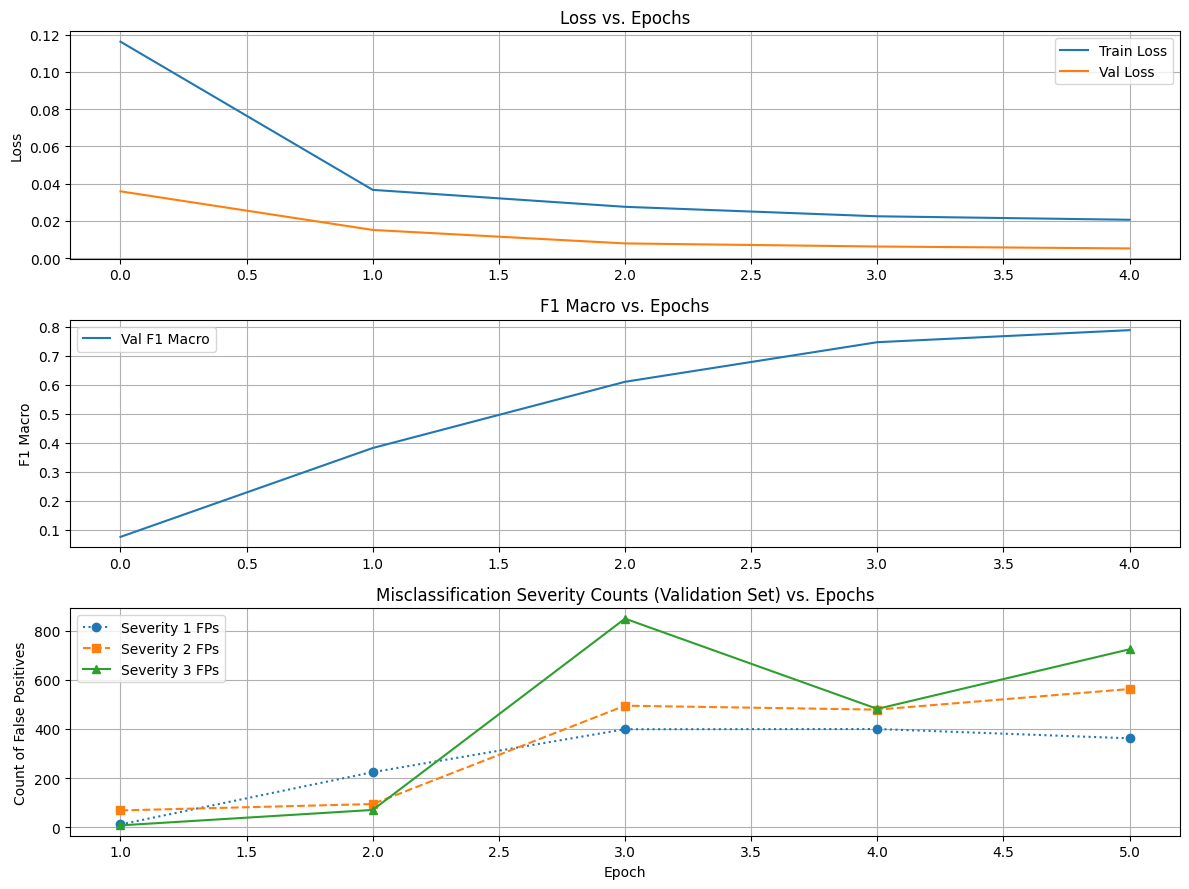


--- Stage 9 (No GloVe): Training Loop Complete ---


In [51]:
# Stage 9 (No GloVe): Training & Evaluation Loop

print("\n--- Stage 9 (No GloVe): Training Loop ---")

# --- Optimizer Setup ---
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
print(f"Optimizer AdamW initialized.")

# --- Scheduler Setup ---
num_training_steps = len(train_loader) * EPOCHS
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=num_training_steps)
print(f"Linear LR scheduler initialized.")


# --- Training & Evaluation Functions (REUSE FROM PREVIOUS SIMPLE MODEL) ---

def train_epoch_simple(model, data_loader, loss_fn, optimizer, device, scheduler):
    # --- (Paste train_epoch_simple code here) ---
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        tfidf_features = batch['tfidf'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        outputs = model(text_features=tfidf_features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    return total_loss / len(data_loader)


def eval_epoch_simple_with_severity(model, data_loader, loss_fn, device, threshold,
                                     index_to_label_map, hierarchy_info_map):
    # --- (Paste eval_epoch_simple_with_severity code here) ---
    model.eval()
    total_loss = 0; all_preds = []; all_labels = []
    severity_counts = {1: 0, 2: 0, 3: 0}; total_fps = 0
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            tfidf_features = batch['tfidf'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            outputs = model(text_features=tfidf_features)
            original_factor = loss_fn.severity_factor
            loss_fn.severity_factor = 0.0 # Calculate eval loss without severity weight
            loss = loss_fn(outputs, labels)
            loss_fn.severity_factor = original_factor # Reset factor
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).cpu().numpy().astype(int)
            labels_np = labels.cpu().numpy().astype(int)
            all_preds.append(preds); all_labels.append(labels_np)
            # Severity Tracking
            for i in range(preds.shape[0]):
                true_indices = np.where(labels_np[i] == 1)[0]
                pred_indices = np.where(preds[i] == 1)[0]
                true_label_strs = [index_to_label_map.get(idx, None) for idx in true_indices]
                true_label_strs = [s for s in true_label_strs if s]
                for pred_idx in pred_indices:
                    if labels_np[i, pred_idx] == 0: # FP
                        total_fps += 1
                        predicted_label_str = index_to_label_map.get(pred_idx, None)
                        if not predicted_label_str: continue
                        severity_level = loss_fn.get_severity(predicted_label_str, true_label_strs)
                        if severity_level > 0: severity_counts[severity_level] += 1
            progress_bar.set_postfix({'eval_loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(data_loader)
    all_preds = np.concatenate(all_preds, axis=0); all_labels = np.concatenate(all_labels, axis=0)
    metrics = {}
    metrics['loss'] = avg_loss
    metrics['f1_micro'] = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    metrics['f1_macro'] = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    # ... (calculate other metrics: f1_samples, hamming, accuracy_subset) ...
    metrics['f1_samples'] = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    metrics['hamming_loss'] = hamming_loss(all_labels, all_preds)
    metrics['accuracy_subset'] = accuracy_score(all_labels, all_preds)
    metrics['severity_counts'] = severity_counts; metrics['total_fps_checked'] = total_fps
    return metrics


# --- Main Training Loop ---
# (Keep this section exactly as before, using the train/eval functions above)
print("\nStarting training...")
best_val_f1_macro = -1.0; best_model_state = None
history = {'train_loss': [], 'val_loss': [], 'val_f1_macro': [],
           'val_severity_1': [], 'val_severity_2': [], 'val_severity_3': []}
patience = 5; patience_counter = 0
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    avg_train_loss = train_epoch_simple(model, train_loader, criterion, optimizer, DEVICE, scheduler)
    history['train_loss'].append(avg_train_loss)
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    val_metrics = eval_epoch_simple_with_severity(model, val_loader, criterion, DEVICE, SEVERITY_THRESHOLD, index_to_label, label_hierarchy_info)
    history['val_loss'].append(val_metrics['loss'])
    history['val_f1_macro'].append(val_metrics['f1_macro'])
    history['val_severity_1'].append(val_metrics['severity_counts'][1])
    history['val_severity_2'].append(val_metrics['severity_counts'][2])
    history['val_severity_3'].append(val_metrics['severity_counts'][3])
    print(f"Validation Loss: {val_metrics['loss']:.4f}"); print(f"Validation F1 Macro: {val_metrics['f1_macro']:.4f}")
    sev_counts = val_metrics['severity_counts']; total_val_fps = val_metrics['total_fps_checked']
    if total_val_fps > 0: print(f"Validation FP Severity Counts (Total Checked: {total_val_fps}): Sev1: {sev_counts[1]} ({sev_counts[1]/total_val_fps:.1%}), Sev2: {sev_counts[2]} ({sev_counts[2]/total_val_fps:.1%}), Sev3: {sev_counts[3]} ({sev_counts[3]/total_val_fps:.1%})")
    else: print("Validation FP Severity Counts: No FPs found.")
    epoch_duration = time.time() - epoch_start_time; print(f"Epoch Duration: {epoch_duration:.2f} seconds")
    current_val_f1_macro = val_metrics['f1_macro']
    if current_val_f1_macro > best_val_f1_macro:
        print(f"Validation F1 Macro improved ({best_val_f1_macro:.4f} --> {current_val_f1_macro:.4f}). Saving model...")
        best_val_f1_macro = current_val_f1_macro; best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, MODEL_SAVE_PATH); patience_counter = 0
    else:
        patience_counter += 1; print(f"Validation F1 Macro did not improve ({best_val_f1_macro:.4f}). Patience: {patience_counter}/{patience}")
    if patience_counter >= patience: print(f"Early stopping triggered."); break
total_training_time = time.time() - start_time
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
print(f"Best Validation F1 Macro achieved: {best_val_f1_macro:.4f}")
try:
    with open(HISTORY_SAVE_PATH, 'wb') as f: pickle.dump(history, f)
    print(f"Training history saved to {HISTORY_SAVE_PATH}")
except Exception as e: print(f"Error saving training history: {e}")

# --- Plot Training History ---
# (Keep plotting code as before)
plt.figure(figsize=(12, 9)); plt.subplot(3, 1, 1)
plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(3, 1, 2); plt.plot(history['val_f1_macro'], label='Val F1 Macro')
plt.title('F1 Macro vs. Epochs'); plt.ylabel('F1 Macro'); plt.legend(); plt.grid(True)
plt.subplot(3, 1, 3); epochs_ran = range(1, len(history['val_severity_1']) + 1)
plt.plot(epochs_ran, history['val_severity_1'], label='Severity 1 FPs', marker='o', linestyle=':')
plt.plot(epochs_ran, history['val_severity_2'], label='Severity 2 FPs', marker='s', linestyle='--')
plt.plot(epochs_ran, history['val_severity_3'], label='Severity 3 FPs', marker='^', linestyle='-')
plt.title('Misclassification Severity Counts (Validation Set) vs. Epochs'); plt.xlabel('Epoch')
plt.ylabel('Count of False Positives'); plt.legend(); plt.grid(True)#; plt.yscale('log')
plt.tight_layout(); plt.savefig("training_history_learnable_gnn.png")
print("\nTraining history plot saved to training_history_learnable_gnn.png"); plt.show()

print("\n--- Stage 9 (No GloVe): Training Loop Complete ---")

In [52]:
# Stage 10 (No GloVe): Final Evaluation

print("\n--- Stage 10 (No GloVe): Final Evaluation ---")

# --- Load Best Model ---
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading best model state from {MODEL_SAVE_PATH}...")
    try:
        # --- *** Instantiate the CORRECT model class *** ---
        model_eval = LearnableGNNClassifier( # Use the new class
            text_input_dim=TFIDF_INPUT_DIM, num_labels=NUM_LABELS, graph_data=graph_data,
            node_embedding_dim=NODE_EMBEDDING_DIM, # Use new config
            gat_hidden_dim=GAT_HIDDEN_DIM, gat_output_dim=GAT_OUTPUT_DIM,
            gat_heads=GAT_HEADS, gat_dropout=GAT_DROPOUT, mlp_hidden_dim=MLP_HIDDEN_DIM,
            classifier_dropout=CLASSIFIER_DROPOUT, device=DEVICE
        )
        model_eval.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        model_eval.to(DEVICE)
        model_eval.eval()
        print("Best model loaded successfully.")
    except Exception as e:
        print(f"Error loading best model state: {e}"); exit()
else:
    print(f"Error: Best model file not found at {MODEL_SAVE_PATH}."); exit()


# --- Evaluate on Test Set ---
# (Reuse the eval_epoch_simple_with_severity function defined in Stage 9)
print("\nEvaluating on Test Set...")
test_metrics = eval_epoch_simple_with_severity(
    model_eval, test_loader, criterion, DEVICE,
    threshold=SEVERITY_THRESHOLD,
    index_to_label_map=index_to_label,
    hierarchy_info_map=label_hierarchy_info
)

# --- Print Test Metrics and Severity Breakdown ---
# (Keep this section exactly as before)
print("\nTest Set Performance:"); print(f"  Test Loss: {test_metrics['loss']:.4f}")
print(f"  Test F1 Micro: {test_metrics['f1_micro']:.4f}"); print(f"  Test F1 Macro: {test_metrics['f1_macro']:.4f}")
print(f"  Test F1 Samples: {test_metrics['f1_samples']:.4f}"); print(f"  Test Hamming Loss: {test_metrics['hamming_loss']:.4f}")
print(f"  Test Subset Accuracy: {test_metrics['accuracy_subset']:.4f}")
test_sev_counts = test_metrics['severity_counts']; test_total_fps = test_metrics['total_fps_checked']
print("\nTest Set Misclassification Severity Breakdown:"); print(f"  Total False Positives Checked: {test_total_fps}")
if test_total_fps > 0:
    print(f"  Severity 1 FPs: {test_sev_counts[1]} ({test_sev_counts[1]/test_total_fps:.2%})")
    print(f"  Severity 2 FPs: {test_sev_counts[2]} ({test_sev_counts[2]/test_total_fps:.2%})")
    print(f"  Severity 3 FPs: {test_sev_counts[3]} ({test_sev_counts[3]/test_total_fps:.2%})")
else: print("  No False Positives found in the test set to analyze severity.")

# --- Optional: Detailed Classification Report ---
# (Keep this section exactly as before)
print("\nGenerating detailed classification report on test set...")
all_preds_test = []; all_labels_test = []
model_eval.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Getting Test Preds"):
        tfidf_features = batch['tfidf'].to(DEVICE); labels = batch['labels']
        outputs = model_eval(text_features=tfidf_features); probs = torch.sigmoid(outputs)
        preds = (probs > SEVERITY_THRESHOLD).cpu().numpy().astype(int)
        all_preds_test.append(preds); all_labels_test.append(labels.numpy().astype(int))
all_preds_test = np.concatenate(all_preds_test, axis=0); all_labels_test = np.concatenate(all_labels_test, axis=0)
try:
    report = classification_report(all_labels_test, all_preds_test, target_names=all_labels_list, zero_division=0, digits=3)
    print("\nClassification Report (Test Set):\n"); print(report)
    report_filename = "classification_report_learnable_gnn_test.txt"
    with open(report_filename, "w") as f: f.write(report)
    print(f"Classification report saved to {report_filename}")
except ValueError as e: print(f"\nCould not generate detailed classification report: {e}")

print("\n--- Stage 10 (No GloVe): Evaluation Complete ---")


--- Stage 10 (No GloVe): Final Evaluation ---
Loading best model state from learnable_gnn_classifier_best.pt...
Initializing Learnable Node Embeddings...
Node Embedding layer created with shape: (298, 256)
Initializing Text MLP...
Text MLP initialized.
Initializing GAT layers...
GAT layers initialized.
Best model loaded successfully.

Evaluating on Test Set...


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]


Test Set Performance:
  Test Loss: 0.0053
  Test F1 Micro: 0.9086
  Test F1 Macro: 0.7897
  Test F1 Samples: 0.8820
  Test Hamming Loss: 0.0017
  Test Subset Accuracy: 0.7330

Test Set Misclassification Severity Breakdown:
  Total False Positives Checked: 1775
  Severity 1 FPs: 376 (21.18%)
  Severity 2 FPs: 595 (33.52%)
  Severity 3 FPs: 804 (45.30%)

Generating detailed classification report on test set...


Getting Test Preds:   0%|          | 0/95 [00:00<?, ?it/s]


Classification Report (Test Set):

                                   precision    recall  f1-score   support

                  AcademicJournal      0.950     0.837     0.890       203
                            Actor      0.988     0.704     0.822       115
                       AdultActor      0.831     0.744     0.785        86
                            Agent      0.981     0.970     0.975     12413
                          Airline      0.989     0.925     0.956       200
                          Airport      0.975     0.935     0.954       168
                            Album      0.891     0.294     0.442       194
                     AmateurBoxer      0.923     0.857     0.889        28
                       Ambassador      0.923     0.300     0.453        40
           AmericanFootballPlayer      0.971     0.860     0.912       193
                        Amphibian      0.994     0.948     0.971       174
          AmusementParkAttraction      1.000     0.967     0.98